In [115]:
# Import packages
import scipy.io as sio
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from set_paths import data_path
import os
import seaborn as sns
from scipy import stats
import matplotlib
import pingouin as pg

In [116]:
### Load data ###

## Load data input to UMAP ##
struct_data = sio.loadmat(os.path.join(data_path, "umap_input_data.mat"))['mat']

# Initialize an empty list to store the field data
field_data_list = []
# Iterate over each field in the struct
for field_name in struct_data.dtype.names:
    # Extract the 2-dimensional array from each field
    field_data = struct_data[field_name][0]
    # Flatten the nested arrays
    field_data_flat = np.concatenate(field_data).ravel()
    # Append the flattened field data to the list
    field_data_list.append(field_data_flat)
# Create the DataFrame from the list of flattened field data
input_data = pd.DataFrame(field_data_list).transpose()
# Column names
colnames = ['age','global_efficiency','path_length', 'small_worldness','strength',
            'modularity', 'core/periphery', 'score', 'local_efficiency', 
            'clustering', 'betweenness', 'subgraph_centrality']
input_data.columns = colnames
ages = input_data['age']
# Group by age
grouped_input_data = input_data.groupby('age').mean().reset_index()

## Load PCA data ##

# Loadings
mat_file = sio.loadmat(os.path.join(data_path, "pca_rotated_loadings.mat"))
pca_loadings = np.array(mat_file['rotated_loadings'])
# Scores
mat_file = sio.loadmat(os.path.join(data_path, "pca_scores.mat"))
pca_scores = np.array(mat_file['score'])
# Cumulative variance
mat_file = sio.loadmat(os.path.join(data_path, "pca_cumvariance_explained.mat"))
pca_cumvar = np.array(mat_file['cumulative_variance_explained'])
# Eigenvalues
mat_file = sio.loadmat(os.path.join(data_path, "pca_eigenvalues.mat"))
pca_eigenvalues = np.array(mat_file['eigenvalues']).flatten()
# Parallel analysis eigenvalues
mat_file = sio.loadmat(os.path.join(data_path, "pca_simulated_eigenvalues.mat"))
pca_sim_eigenvalues = np.array(mat_file['simulated_eigenvalues']).flatten()

In [103]:
### Define variables ###

# Metrics
measures = ['Global Efficiency', 'Path Length', 'Small-Worldness','Strength',
                  'Modularity', 'Core/Periphery', 'S-Core', 'Local Efficiency', 
                  'Clustering Coefficient', 'Betweenness Centrality', 'Subgraph Centrality']
# Epochs
epoch_ranges = [
    (0,8),
    (8,32),
    (32,62),
    (62,85),
    (85,90)]

# Colors for epochs
line_colors = ['#FF5AAF','#008DF9','#FFC33B','#009F81','#A40122']

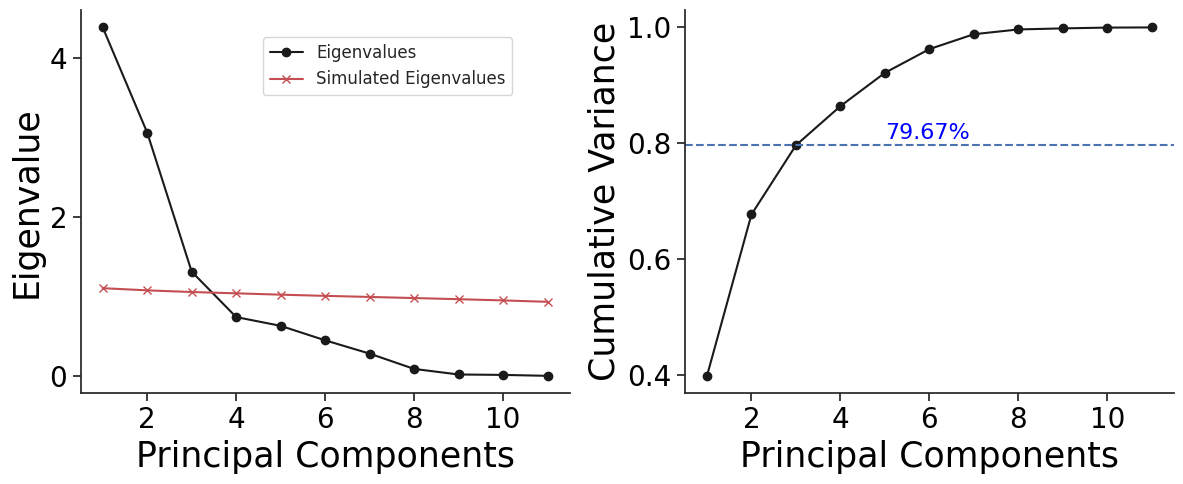

In [104]:
### Figure 5a ###

# Scree Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange(1, len(pca_eigenvalues) + 1), pca_eigenvalues, 'ko-', label='Eigenvalues')
plt.plot(np.arange(1, len(pca_sim_eigenvalues) + 1), pca_sim_eigenvalues, 'rx-', label='Simulated Eigenvalues')
plt.xlabel('Principal Components',color='black',  family='Arial', fontsize=25)
plt.ylabel('Eigenvalue',family='Arial',color='black',fontsize=25)
plt.xticks([2,4,6,8,10],color='black',family='Arial',size=20)
plt.yticks([0,2,4],color='black',family='Arial',size=20)
plt.grid(False)
# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
# Add Legend outside the graph on the top right
plt.legend(loc='upper right', bbox_to_anchor=(0.9, 0.95),fontsize=12)

# Cumulative Variance Explained Plot
plt.subplot(1, 2, 2)
plt.plot(np.arange(1, len(pca_cumvar) + 1), pca_cumvar, 'ko-', label='Cumulative Variance')
plt.axhline(y=pca_cumvar[2], color='b', linestyle='--')
plt.annotate(f'{float(pca_cumvar[2])*100:.2f}%', xy=(5, pca_cumvar[2]), xytext=(5, pca_cumvar[2] + 0.01),
             fontsize=16,color='blue')
plt.xlabel('Principal Components',color='black', family='Arial', fontsize=25)
plt.ylabel('Cumulative Variance',color='black', family='Arial', fontsize=25)
plt.xticks([2,4,6,8,10],color='Black',family='Arial',fontsize=20)
plt.yticks([0.4,0.6,0.8,1.0],color='black',size=20)
plt.grid(False)
# Remove the box around the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

In [105]:
# Function to get the line color based on the index to identify integration, segregation and centrality metrics
# Define group colors
group_colors = ['#ee5038', '#00a78e', '#405eaa']

def get_line_color(index):
    if index < 4:
        return group_colors[0]
    elif 4 <= index <= 8:
        return group_colors[1]
    else:
        return group_colors[2]

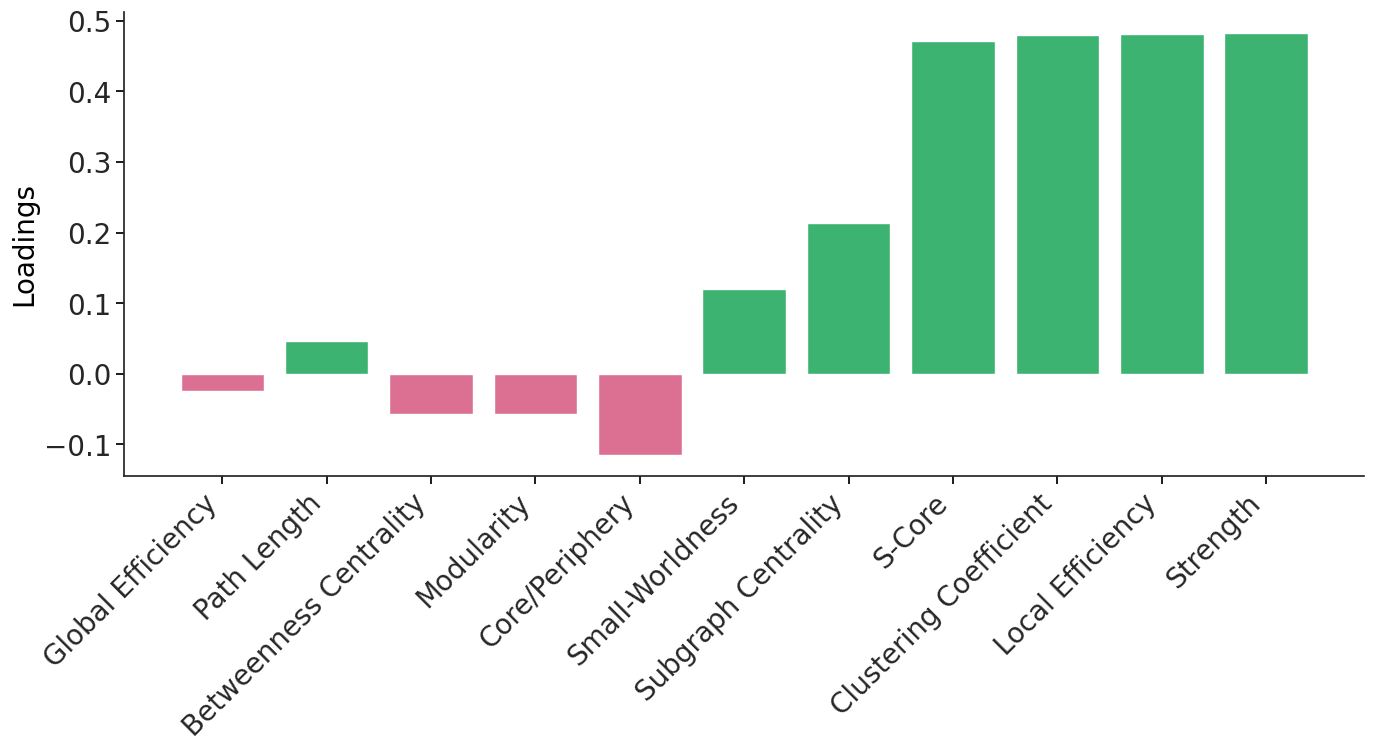

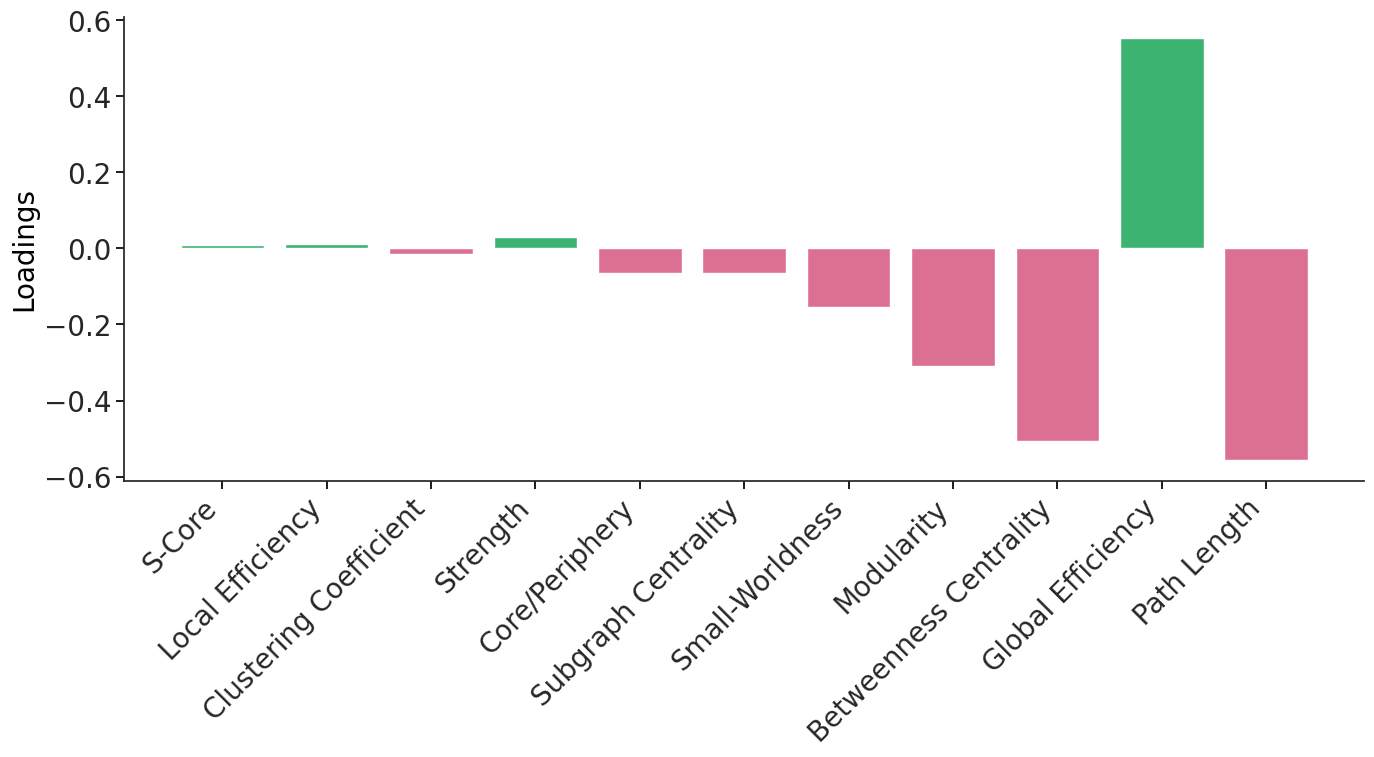

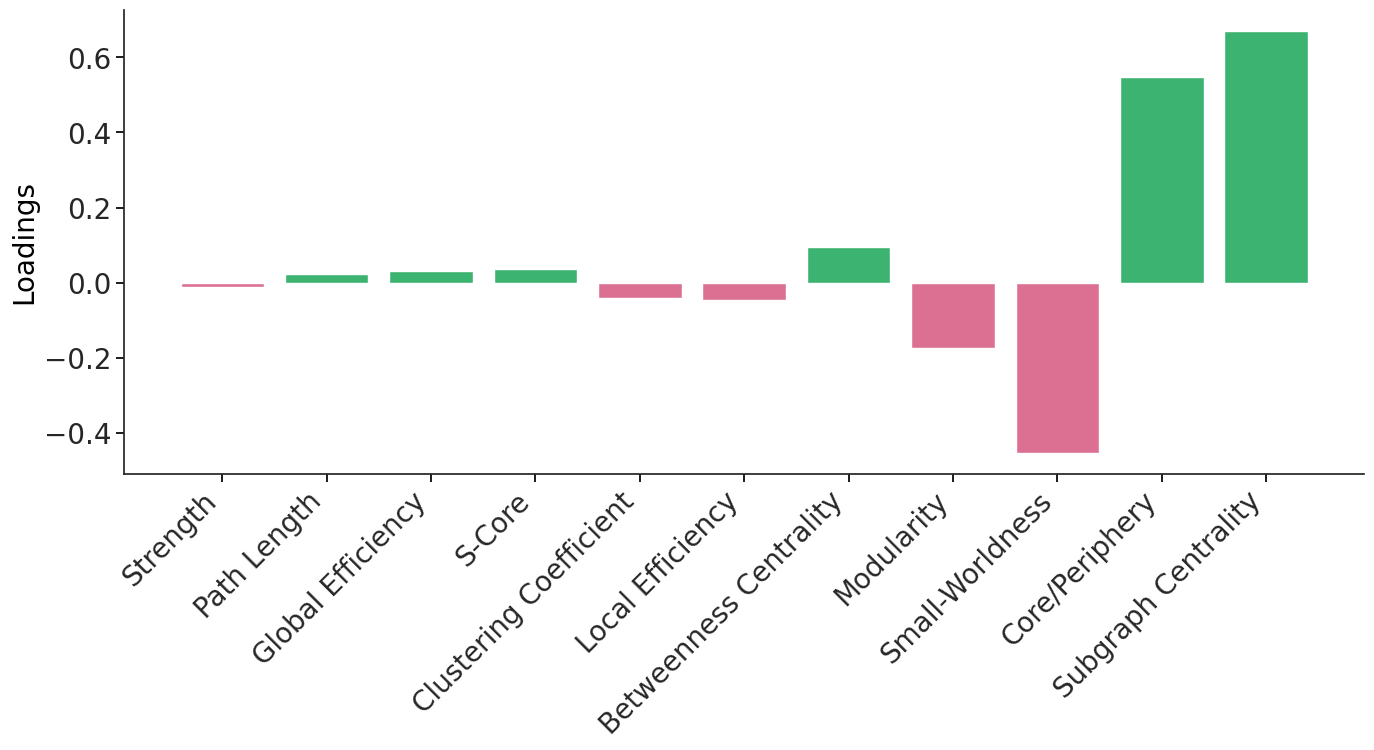

In [106]:
### Extended Data Figure 3b-d ###

# Loop through each PCA component
for i in range(3):
    # Get indices of the =loadings (positive or negative)
    top_indices = np.argsort(np.abs(pca_loadings[:, i])) 

    # Sort bars
    top_loadings = pca_loadings[top_indices, i]
    top_predictors = [measures[idx] for idx in top_indices]

    # Create a bar plot
    plt.figure(figsize=(16,8))
    plt.bar(top_predictors, top_loadings, color=np.where(top_loadings >= 0, 'mediumseagreen', 'palevioletred'))

    # Set plot title and labels
    plt.ylabel('Loadings', color='black', family='Arial', fontsize=20)
    plt.tick_params(axis='x', labelsize=20,color='black')  
    plt.xticks(rotation=45, ha='right')  
    plt.tick_params(axis='y', labelsize=20,color='black')
    plt.subplots_adjust(bottom=0.3)

    # Plot
    plt.show()

In [107]:
### Figure 5a ###

# Standarize the scores
std_scores = pca_scores / np.std(pca_scores, axis=0)
std_loadings = pca_loadings * np.max(np.abs(pca_scores))


# Make abbreviations (note: these abbreviations were replaced with full labels in the figure)
predabb = ['GE', 'PL', 'SW','Str','Mod', 'C/P', 'SC', 'LE', 'CC', 'BC', 'SC']

# Create a 3D biplot
fig = go.Figure()

# Plot PCA loadings as lines
for i in range(len(measures)):
    text_position = 'middle right'  # Default text position

    # Change text position fo SC and CC for better visualization
    if predabb[i] == 'SC':
        text_position = 'top right'
    elif predabb[i] == 'CC':
        text_position = 'bottom right'

        
    fig.add_trace(go.Scatter3d(
        x=[0, pca_loadings[i, 0]],
        y=[0, pca_loadings[i, 1]],
        z=[0, pca_loadings[i, 2]],
        mode='lines+text',
        line=dict(color=get_line_color(i), width=8),
        showlegend=False,
        # Comment out these 6 lines to remove abberviations
        text=[None, predabb[i]],
        textposition=text_position,    
        textfont=dict(
            family="Arial, sans-serif",
            size=16,
            color='black')
    ))
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=13), 
            titlefont=dict(color='black', size=30, family='Arial'),
            range = [-0.5,0.5],
            tickvals=[-0.4, 0, 0.4]
        ),
        yaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=13), 
            titlefont=dict(color='black', size=30, family='Arial'),
            tickvals=[-0.4,0,0.4]
        ),
        zaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=13), 
            titlefont=dict(color='black', size=30, family='Arial'),
            tickvals=[-0.2,0.2,0.6]
        )
    ),
    scene_camera=dict(
        eye=dict(x=2.5, y=2, z=2) 
    )
)
# Show the plot
fig.show()

In [108]:
### Extended Data Figure 3e ###

# Create a DataFrame with standardized scores and age
df_scores = pd.DataFrame(pca_scores, columns=['PC1', 'PC2', 'PC3'])
df_scores['Age'] = input_data['age']
df_avg_scores = df_scores.groupby('Age').mean().reset_index()

# Create a 3D biplot
fig = go.Figure()
# Plot PCA loadings as arrows and label predictors with different colors
for i in range(len(measures)):
    # Define custom legend names
    legend_name = 'Integration' if i == 0 else ('Segregation' if i == 6 else ('Centrality' if i == 10 else predabb[i]))

    fig.add_trace(go.Scatter3d(
        x=[0, pca_loadings[i, 0]*8],
        y=[0, pca_loadings[i, 1]*8],
        z=[0, pca_loadings[i, 2]*8],
        mode='lines',
        line=dict(color=get_line_color(i), width=6)
    ))

# Scatter plot of PCA scores colored by 'age'
fig.add_trace(go.Scatter3d(
    x=df_avg_scores['PC1'],
    y=df_avg_scores['PC2'],
    z=df_avg_scores['PC3'],
    mode='markers',
    marker=dict(
        size=10,
        color=df_avg_scores['Age'],
        colorscale='inferno',
        opacity=0.8,
        colorbar=dict(title='Age')
    ), showlegend= False
))

fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='PC1',
            linecolor='black',
            tickcolor='black',
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black'),
            titlefont=dict(color='black', size=10, family='Arial')
        ),
        yaxis=dict(
            title='PC2',
            linecolor='black',
            tickcolor='black',
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black'),
            titlefont=dict(color='black', size=10, family='Arial')
        ),
        zaxis=dict(
            title='PC3',
            linecolor='black',
            tickcolor='black',
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black'),
            titlefont=dict(color='black', size=10, family='Arial')
        )
    ),
    scene_camera=dict(
        eye=dict(x=2.5, y=2, z=2)  
    )
)
# Show the plot
fig.show()

In [109]:
# Select PCA scores based on epochs
pca_scores = pd.DataFrame(pca_scores, columns=['PC1', 'PC2', 'PC3'])
epoch_data1 = pca_scores[(input_data['age'] >= epoch_ranges[0][0]) & (input_data['age'] <= epoch_ranges[0][1])]
epoch_data2 = pca_scores[(input_data['age'] >= epoch_ranges[1][0]) & (input_data['age'] <= epoch_ranges[1][1])]
epoch_data3 = pca_scores[(input_data['age'] >= epoch_ranges[2][0]) & (input_data['age'] <= epoch_ranges[2][1])]
epoch_data4 = pca_scores[(input_data['age'] >= epoch_ranges[3][0]) & (input_data['age'] <= epoch_ranges[3][1])]
epoch_data5 = pca_scores[(input_data['age'] >= epoch_ranges[4][0]) & (input_data['age'] <= epoch_ranges[4][1])]

# Get PCA socre averages per epoch
averages = pd.DataFrame({'PC1': [np.mean(epoch_data1['PC1']),np.mean(epoch_data2['PC1']),np.mean(epoch_data3['PC1']),np.mean(epoch_data4['PC1']),np.mean(epoch_data5['PC1'])],
                         'PC2': [np.mean(epoch_data1['PC2']),np.mean(epoch_data2['PC2']),np.mean(epoch_data3['PC2']),np.mean(epoch_data4['PC2']),np.mean(epoch_data5['PC2'])],
                         'PC3': [np.mean(epoch_data1['PC3']),np.mean(epoch_data2['PC3']),np.mean(epoch_data3['PC3']),np.mean(epoch_data4['PC3']),np.mean(epoch_data5['PC3'])]})

In [110]:
### Figure 5a ###

labels = ['Epoch: 0-8', 'Epoch: 8-32', 'Epoch: 32-62', 'Epoch: 62-85', 'Epoch: 85-90']

# Create a 3D scatter plot with separate traces for each epoch
fig = go.Figure()

for i in range(len(averages)):
    fig.add_trace(go.Scatter3d(
        x=[averages.loc[i, 'PC1']],
        y=[averages.loc[i, 'PC2']],
        z=[averages.loc[i, 'PC3']],
        mode='markers',
        marker=dict(size=10, color=line_colors[i]),
        name=labels[i]
    ))

# Update layout to show legend
fig.update_layout(showlegend=True)
fig.update_layout(
    scene=dict(
        xaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=15),  
            titlefont=dict(color='black', size=30, family='Arial'),
            range=[-1.5, 2.5],
            tickvals=[-1, 0, 1, 2],
            tickwidth=2,  
            ticklen=10  
        ),
        yaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=15),  
            titlefont=dict(color='black', size=30, family='Arial'),
            range=[-1, 1],
        ),
        zaxis=dict(
            title='',
            linecolor='black',
            tickcolor='black',
            linewidth=10,
            showgrid=False,
            showbackground=False,
            tickfont=dict(color='black', size=15),  
            titlefont=dict(color='black', size=30, family='Arial'),
            range=[-1, 3],
            tickvals=[0, 1, 2, 3],
        ),
        camera=dict(
            eye=dict(x=-2, y=3, z=2.5)  
        )
    )
)
# Show the plot
fig.show()

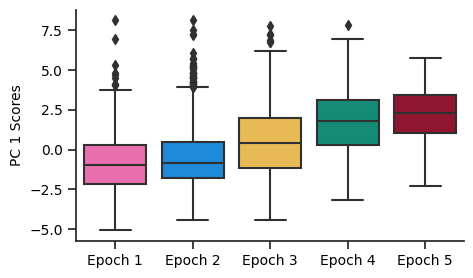

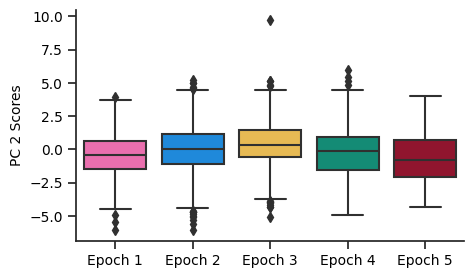

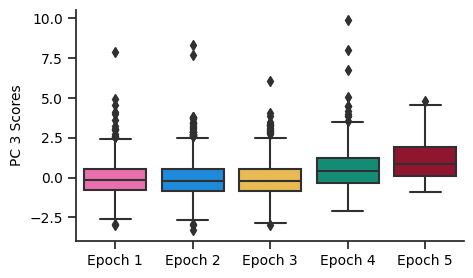

In [111]:
### Extended Data Figure 4b ###

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

## PC1 ##
plt.figure(figsize=(5, 3))
sns.boxplot(x='Epoch', y='PC1', data=pd.concat([epoch_data1.assign(Epoch='Epoch 1'),
                                                epoch_data2.assign(Epoch='Epoch 2'),
                                                epoch_data3.assign(Epoch='Epoch 3'),
                                                epoch_data4.assign(Epoch='Epoch 4'),
                                                epoch_data5.assign(Epoch='Epoch 5')]),
            palette=line_colors)
plt.ylabel('PC 1 Scores',color='black', family='Arial', fontsize=10)
plt.yticks(color='black',family='Arial',size=10)
plt.xticks(color='black',family='Arial',size=10)
plt.xlabel('')
plt.show()

## PC 2 ##
plt.figure(figsize=(5, 3))
sns.boxplot(x='Epoch', y='PC2', data=pd.concat([epoch_data1.assign(Epoch='Epoch 1'),
                                                epoch_data2.assign(Epoch='Epoch 2'),
                                                epoch_data3.assign(Epoch='Epoch 3'),
                                                epoch_data4.assign(Epoch='Epoch 4'),
                                                epoch_data5.assign(Epoch='Epoch 5')]),
            palette=line_colors)
plt.ylabel('PC 2 Scores',color='black', family='Arial', fontsize=10)
plt.yticks(color='black',family='Arial',size=10)
plt.xticks(color='black',family='Arial',size=10)
plt.xlabel('')
plt.show()

## PC 3 ##
plt.figure(figsize=(5, 3))
sns.boxplot(x='Epoch', y='PC3', data=pd.concat([epoch_data1.assign(Epoch='Epoch 1'),
                                                epoch_data2.assign(Epoch='Epoch 2'),
                                                epoch_data3.assign(Epoch='Epoch 3'),
                                                epoch_data4.assign(Epoch='Epoch 4'),
                                                epoch_data5.assign(Epoch='Epoch 5')]),
            palette=line_colors)
plt.ylabel('PC 3 Scores',color='black', family='Arial', fontsize=10)
plt.yticks(color='black',family='Arial',size=10)
plt.xticks(color='black',family='Arial',size=10)
plt.xlabel('')
plt.show()

In [112]:
### PC 1 statistics ###

# Pull PC 1
pc_1 = [epoch_data1['PC1'], epoch_data2['PC1'], epoch_data3['PC1'], epoch_data4['PC1'], epoch_data5['PC1']]
alpha = 0.05 # P-value cut-off

# Perform Levene's test for homogeneity of variance
statistic, p_value_levene = stats.levene(*pc_1)
print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value_levene)

# Check if there is a significant difference in variation
if p_value_levene < alpha:
    print("Levene's test is significant")

    # Calculate variance for each epoch
    variances = [np.var(data) for data in pc_1]
    print("Variances per epoch:")
    for i, var in enumerate(variances):
        print(f"Epoch {i+1}: {var}")
else:
    print("Levene's test is not significant")

## Because of significant Levene's, run Welch's ANOVA (does not assume equal variances)  ##

# Concatenate the data with group labels
data = pd.concat(pc_1, keys=['group1', 'group2', 'group3', 'group4', 'group5'], names=['group', 'index']).reset_index()
grouped_data = data.groupby('group').agg({'PC1': ['mean', 'std']})
# Flatten the multi-level columns
grouped_data.columns = ['mean', 'std']
# Display the result
print(grouped_data)

# Perform Welch's ANOVA
wanova = pg.welch_anova(dv='PC1', between='group', data=data)
print(wanova)
# Pariwise Gameshowell to tes group specific differences
group_diff = pg.pairwise_gameshowell(dv='PC1', between='group', data=data,effsize='cohen')
group_diff

Levene's test statistic: 11.286710511455547
Levene's test p-value: 4.160599531403381e-09
Levene's test is significant
Variances per epoch:
Epoch 1: 3.431405741663565
Epoch 2: 3.3343950174742734
Epoch 3: 4.217953584273165
Epoch 4: 3.9154214926857622
Epoch 5: 3.297048881764797
            mean       std
group                     
group1 -0.858605  1.853877
group2 -0.510277  1.826543
group3  0.512066  2.054787
group4  1.725775  1.980640
group5  2.153951  1.832210
  Source  ddof1       ddof2           F         p-unc      np2
0  group      4  381.067852  201.284182  1.418516e-92  0.17075


,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,group1,group2,-0.858605,-0.510277,-0.348328,0.085546,-4.071818,1087.348164,4.795545e-04,-0.189960
1,group1,group3,-0.858605,0.512066,-1.370671,0.098246,-13.951399,1436.848541,0.000000e+00,-0.692306
2,group1,group4,-0.858605,1.725775,-2.584380,0.113888,-22.692238,1080.382366,0.000000e+00,-1.351417
3,group1,group5,-0.858605,2.153951,-3.012556,0.255738,-11.779875,65.418518,3.264056e-14,-1.626523
4,group2,group3,-0.510277,0.512066,-1.022343,0.077844,-13.133152,1886.454017,0.000000e+00,-0.534767
5,group2,group4,-0.510277,1.725775,-2.236052,0.096840,-23.090157,797.036878,0.000000e+00,-1.200631
6,group2,group5,-0.510277,2.153951,-2.664228,0.248614,-10.716305,58.469547,6.217249e-15,-1.458483
7,group3,group4,0.512066,1.725775,-1.213709,0.108223,-11.214909,1089.290850,6.536993e-13,-0.597952
8,group3,group5,0.512066,2.153951,-1.641885,0.253265,-6.482866,62.954035,1.563623e-07,-0.803336
9,group4,group5,1.725775,2.153951,-0.428176,0.259734,-1.648521,69.539240,4.721912e-01,-0.217685


In [113]:
### PC 2 statistics ###

pc_2 = [epoch_data1['PC2'], epoch_data2['PC2'], epoch_data3['PC2'], epoch_data4['PC2'], epoch_data5['PC2']]
alpha = 0.05
# Perform Levene's test for homogeneity of variance
statistic, p_value_levene = stats.levene(*pc_2)
print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value_levene)

# Check if there is a significant difference in variation
if p_value_levene < alpha:
    print("Levene's test is significant")

    # Calculate variance for each epoch
    variances = [np.var(data) for data in pc_2]
    print("Variances per epoch:")
    for i, var in enumerate(variances):
        print(f"Epoch {i+1}: {var}")
else:
    print("Levene's test is not significant")

## Because of significant Levene's, run Welch's ANOVA (does not assume equal variances) ##

# Concatenate the data with group labels
data = pd.concat(pc_2, keys=['group1', 'group2', 'group3', 'group4', 'group5'], names=['group', 'index']).reset_index()
# Group by the 'group' level and calculate the mean for each group
group_means = data.groupby('group').mean()


grouped_data = data.groupby('group').agg({'PC2': ['mean', 'std']})
# Flatten the multi-level columns
grouped_data.columns = ['mean', 'std']
# Display the result
print(grouped_data)

# Perform Welch's ANOVA
wanova = pg.welch_anova(dv='PC2', between='group', data=data)
print(wanova)
# Pariwise Gameshowell to tes group specific differences
group_diff = pg.pairwise_gameshowell(dv='PC2', between='group', data=data,effsize='cohen')
group_diff

Levene's test statistic: 7.6929453515359665
Levene's test p-value: 3.58847024401516e-06
Levene's test is significant
Variances per epoch:
Epoch 1: 2.4232036945076425
Epoch 2: 2.9992884637325146
Epoch 3: 2.7922167253027417
Epoch 4: 3.7207326552367648
Epoch 5: 3.9977772321759333
            mean       std
group                     
group1 -0.418625  1.557901
group2  0.015632  1.732329
group3  0.395763  1.671824
group4 -0.209069  1.930770
group5 -0.783904  2.017539
  Source  ddof1       ddof2          F         p-unc       np2
0  group      4  378.627215  28.991454  4.894570e-21  0.026692


,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,group1,group2,-0.418625,0.015632,-0.434257,0.074351,-5.840639,1214.411663,6.655990e-08,-0.257153
1,group1,group3,-0.418625,0.395763,-0.814388,0.081430,-10.001121,1405.783339,0.000000e+00,-0.499958
2,group1,group4,-0.418625,-0.209069,-0.209556,0.104852,-1.998584,994.906387,2.673657e-01,-0.120658
3,group1,group5,-0.418625,-0.783904,0.365279,0.276657,1.320331,60.969625,6.797522e-01,0.228335
4,group2,group3,0.015632,0.395763,-0.380132,0.066738,-5.695917,2144.764446,1.392468e-07,-0.222193
5,group2,group4,0.015632,-0.209069,0.224701,0.093899,2.392992,781.635987,1.182488e-01,0.126307
6,group2,group5,0.015632,-0.783904,0.799536,0.272695,2.931981,57.564011,3.734122e-02,0.459106
7,group3,group4,0.395763,-0.209069,0.604832,0.099598,6.072710,932.097878,1.826743e-08,0.342776
8,group3,group5,0.395763,-0.783904,1.179668,0.274709,4.294241,59.280169,6.117231e-04,0.697409
9,group4,group5,-0.209069,-0.783904,0.574835,0.282539,2.034533,66.270948,2.612485e-01,0.296426


In [114]:
### PC 3 statistics ###
pc_3 = [epoch_data1['PC3'], epoch_data2['PC3'], epoch_data3['PC3'], epoch_data4['PC3'], epoch_data5['PC3']]
alpha = 0.05
# Perform Levene's test for homogeneity of variance
statistic, p_value_levene = stats.levene(*pc_3)
print("Levene's test statistic:", statistic)
print("Levene's test p-value:", p_value_levene)


# Check if there is a significant difference in variation
if p_value_levene < alpha:
    print("Levene's test is significant")

    # Calculate variance for each epoch
    variances = [np.var(data) for data in pc_3]
    print("Variances per epoch:")
    for i, var in enumerate(variances):
        print(f"Epoch {i+1}: {var}")
else:
    print("Levene's test is not significant")

## Because of significant Levene's, run Welch's ANOVA (does not assume equal variances) ##

# Concatenate the data with group labels
data = pd.concat(pc_3, keys=['epoch1', 'epoch2', 'epoch3', 'epoch4', 'epoch5'], names=['epoch', 'index']).reset_index()
grouped_data = data.groupby('epoch').agg({'PC3': ['mean', 'std']})
# Flatten the multi-level columns
grouped_data.columns = ['mean', 'std']
# Display the result
print(grouped_data)

# Perform Welch's ANOVA
wanova = pg.welch_anova(dv='PC3', between='epoch', data=data)
print(wanova)
# Pariwise Gameshowell to tes group specific differences
group_diff = pg.pairwise_gameshowell(dv='PC3', between='epoch', data=data,effsize='cohen')
group_diff

Levene's test statistic: 5.265035105818507
Levene's test p-value: 0.00031520642921578873
Levene's test is significant
Variances per epoch:
Epoch 1: 1.1398444983965472
Epoch 2: 1.1699753808792819
Epoch 3: 1.1982678249722498
Epoch 4: 1.6775251472245503
Epoch 5: 1.8403752816999541
            mean       std
epoch                     
epoch1 -0.045981  1.068483
epoch2 -0.109386  1.081956
epoch3 -0.130092  1.095199
epoch4  0.520245  1.296435
epoch5  1.129654  1.368882
  Source  ddof1       ddof2          F         p-unc       np2
0  epoch      4  376.914323  37.895171  1.190134e-26  0.048079


,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,epoch1,epoch2,-0.045981,-0.109386,0.063404,0.049657,1.276858,1113.660986,7.055597e-01,0.058791
1,epoch1,epoch3,-0.045981,-0.130092,0.084111,0.054813,1.534503,1360.407562,5.400982e-01,0.077522
2,epoch1,epoch4,-0.045981,0.520245,-0.566227,0.070936,-7.982173,1008.009689,0.000000e+00,-0.480979
3,epoch1,epoch5,-0.045981,1.129654,-1.175635,0.187812,-6.259622,61.102865,4.175142e-07,-1.072966
4,epoch2,epoch3,-0.109386,-0.130092,0.020706,0.042964,0.481943,2061.127412,9.890142e-01,0.019054
5,epoch2,epoch4,-0.109386,0.520245,-0.629631,0.062237,-10.116677,745.057414,1.773026e-13,-0.555300
6,epoch2,epoch5,-0.109386,1.129654,-1.239039,0.184702,-6.708301,57.169000,9.490976e-08,-1.135067
7,epoch3,epoch4,-0.130092,0.520245,-0.650337,0.066424,-9.790722,913.368800,0.000000e+00,-0.556887
8,epoch3,epoch5,-0.130092,1.129654,-1.259746,0.186155,-6.767188,58.985288,6.629156e-08,-1.133825
9,epoch4,epoch5,0.520245,1.129654,-0.609409,0.191523,-3.181902,66.029459,1.833168e-02,-0.467507
